# Automation and model monitoring 

**Introduction to MLRun - Pip**

????

Tutorial steps:
- [**Run simple workflow with batch predict**](#batch-predict)
- [**Run full workflow with deploy and model monitoring**](#full-workflow)
- [**Model Monitoring Outcomes**](#model-monitoring)

In [1]:
import mlrun
project_name = "ny-taxi-demo-02"
# get/create a project and register the data prep and trainer function in it
project = mlrun.get_or_create_project(
    name=project_name, user_project=True, context="./"
)

> 2022-11-21 09:04:24,196 [info] Username was normalized to match the required pattern for project name: {'username': 'Davesh', 'normalized_username': 'davesh'}
> 2022-11-21 09:04:24,197 [info] Username was normalized to match the required pattern for project name: {'username': 'Davesh', 'normalized_username': 'davesh'}
> 2022-11-21 09:04:24,249 [info] loaded project ny-taxi-demo-02 from MLRun DB


<a id="full-workflow"></a>
## Run full workflow with deploy and model monitoring

Now you can do the same with another workflow you defiend


In [2]:
# Register the workflow file:
workflow_name = "train_workflow"
project.set_workflow(workflow_name, "src/train_workflow.py")

# Save the project:
project.save()

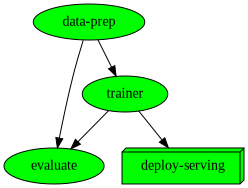

> 2022-11-21 09:14:01,961 [warning] No slack webhook is set, skipping notification
[info] Workflow 5c4db665-034a-4b63-bb57-e2baa93445e2 finished, state=Succeeded
status     name       uid       results
---------  ---------  --------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
completed  evaluate   ..f2cb91  evaluation_mean_absolute_error=1.7585336224210324,evaluation_r2_score=0.8293804012554524,evaluation_root_mean_squared_error=4.031391590921646,evaluation_mean_squared_error=16.252118159353763
completed  trainer    ..d84091  best_iteration=25,mean_absolute_error=1.712230995560711,r2_score=0.8364230781924074,root_mean_squared_error=3.9651004741144185,mean_squared_error=15.722021769822385
completed  data-prep  ..530ff9  label_column=fare_amount


uid,start,state,name,parameters,results
...82f2cb91,Nov 21 09:10:02,completed,evaluate,model=store://artifacts/ny-taxi-demo-02-davesh/lgbm_ny_taxi:5c4db665-034a-4b63-bb57-e2baa93445e2label_columns=fare_amount,evaluation_mean_absolute_error=1.7585336224210324evaluation_r2_score=0.8293804012554524evaluation_root_mean_squared_error=4.031391590921646evaluation_mean_squared_error=16.252118159353763
...07d84091,Nov 21 09:04:50,completed,trainer,,best_iteration=25mean_absolute_error=1.712230995560711r2_score=0.8364230781924074root_mean_squared_error=3.9651004741144185mean_squared_error=15.722021769822385
...8f530ff9,Nov 21 09:04:34,completed,data-prep,,label_column=fare_amount


In [3]:
workflow_run = project.run(
    name=workflow_name,
    arguments={
        "dataset": "https://s3.us-east-1.wasabisys.com/iguazio/data/nyc-taxi/train.csv",
        "project_name": project_name
    },
    watch=True,
)

In [4]:
serving_function = project.get_function("serving")

In [5]:
response = serving_function.invoke(path='/predict', body= {'pickup_longitude':-1.291193, 'pickup_latitude':0.711038, 'dropoff_longitude':-1.291353, 'dropoff_latitude': 0.710814, 
                                               'passenger_count':1, 'jfk_dist':40.446493, 'ewr_dist':32.342093, 'lga_dist':21.273835, 'sol_dist':14.063759, 'nyc_dist':5.607925, 
                                               'timestamp': '2013-01-01T12'})
print(response['result_str'])

> 2022-11-21 09:14:02,212 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-ny-taxi-demo-02-davesh-serving.default-tenant.svc.cluster.local:8080/predict'}
b'predicted fare amount is 7.118997273246077'


### Simulate incoming data

In [6]:
from src.data_prep import *
import numpy as np
# Load the dataset
data = mlrun.get_dataitem("data/dataset.csv").as_df()

data = radian_conv_step(add_airport_dist(clean_df(data).dropna(how="any", axis="rows"))).drop(columns=["key", 'fare_amount']).rename(columns={'pickup_datetime': 'timestamp'})

In [7]:
from random import choice, uniform
from time import sleep
from tqdm.notebook import trange, tqdm

# Sending random requests
for i in trange(150):
    data_point = data.iloc[i].to_dict()
    try:
        resp = serving_function.invoke(path='/predict', body=data_point)
        print(resp)
        sleep(uniform(0.2, 1.7))
    except OSError:
        pass

  0%|          | 0/150 [00:00<?, ?it/s]

> 2022-11-21 09:14:03,160 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-ny-taxi-demo-02-davesh-serving.default-tenant.svc.cluster.local:8080/predict'}
b'predicted fare amount is 5.302605247593433'
> 2022-11-21 09:14:04,841 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-ny-taxi-demo-02-davesh-serving.default-tenant.svc.cluster.local:8080/predict'}
b'predicted fare amount is 17.292622190104602'
> 2022-11-21 09:14:05,911 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-ny-taxi-demo-02-davesh-serving.default-tenant.svc.cluster.local:8080/predict'}
b'predicted fare amount is 5.06771841200699'
> 2022-11-21 09:14:07,316 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-ny-taxi-demo-02-davesh-serving.default-tenant.svc.cluster.local:8080/predict'}
b'predicted fare amount is 9.056179086982818'
> 2022-11-21 09:14:08,554 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-ny-taxi-demo-02-davesh-serving

<a id="model-monitoring"></a>
## Model Monitoring Outcomes


<a id="batch-predict"></a>
## Run simple workflow with batch predict

You should use `project.set_workflow()` for load your workflow into the project, and when you can run it by using `project.run()` while the param name is key.


In [8]:
# Register the workflow file:
workflow_name = "predict_workflow"
project.set_workflow(workflow_name, "src/predict_workflow.py")

# Save the project:
project.save()

In [9]:
workflow_run = project.run(
    name=workflow_name,
    arguments={
        "batch": "https://s3.us-east-1.wasabisys.com/iguazio/data/nyc-taxi/test.csv",
        "model": str(project.get_artifact('lgbm_ny_taxi').uri),
    },
    watch=True,
    engine='local'
)

> 2022-11-21 09:28:18,611 [warning] WARNING!, you seem to have uncommitted git changes, use .push()
> 2022-11-21 09:28:18,623 [warning] No slack webhook is set, skipping notification
[info] Pipeline started in project ny-taxi-demo-02-davesh id=071045b8e7154f738773c282707dcc19, check progress in https://dashboard.default-tenant.app.yh43.iguazio-cd1.com/mlprojects/ny-taxi-demo-02-davesh/jobs


> 2022-11-21 09:28:18,626 [info] starting run data-prep uid=00155472de224166930d7520e5f1802b DB=http://mlrun-api:8080
> 2022-11-21 09:28:18,890 [info] Job is running in the background, pod: data-prep-fd9s4
> 2022-11-21 09:28:27,678 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
ny-taxi-demo-02-davesh,...e5f1802b,0,Nov 21 09:28:23,completed,data-prep,workflow=071045b8e7154f738773c282707dcc19v3io_user=Daveshkind=jobowner=Daveshmlrun/client_version=1.2.0-rc10host=data-prep-fd9s4,dataset,test_size=0,label_column=fare_amount,train_datasettest_dataset


> 2022-11-21 09:28:28,435 [info] run executed, status=completed
> 2022-11-21 09:28:28,678 [error] error getting build status: 404 Client Error: Not Found for url: http://mlrun-api:8080/api/v1/build/status?name=batch-inference&project=ny-taxi-demo-02-davesh&tag=&logs=no&offset=0&last_log_timestamp=0&verbose=no: details: {'reason': "MLRunNotFoundError('Function tag not found ny-taxi-demo-02-davesh/batch-inference')"}
> 2022-11-21 09:28:28,679 [info] Function is not deployed and auto_build flag is set, starting deploy...
> 2022-11-21 09:28:28,838 [info] Started building image: .mlrun/func-ny-taxi-demo-02-davesh-batch-inference:latest

> 2022-11-21 09:31:06,127 [info] starting run batch-inference-infer uid=87863f8d579a441894161239b7a32f0c DB=http://mlrun-api:8080
> 2022-11-21 09:31:06,381 [info] Job is running in the background, pod: batch-inference-infer-7h285
> 2022-11-21 09:31:12,054 [info] Loading model...
> 2022-11-21 09:31:14,075 [info] Loading data...
> 2022-11-21 09:31:14,226 [info

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
ny-taxi-demo-02-davesh,...b7a32f0c,0,Nov 21 09:31:11,completed,batch-inference-infer,workflow=071045b8e7154f738773c282707dcc19v3io_user=Daveshkind=jobowner=Daveshmlrun/client_version=1.2.0-rc10host=batch-inference-infer-7h285,dataset,model=store://artifacts/ny-taxi-demo-02-davesh/lgbm_ny_taxi#0:5c4db665-034a-4b63-bb57-e2baa93445e2perform_drift_analysis=True,batch_id=0da9d5bcbfbd4672fdd42b0c7f3faa88784b1c6187a594c97fd69336drift_status=Falsedrift_metric=0.04036080575576147,predictiondrift_table_plotfeatures_drift_results


> 2022-11-21 09:31:15,991 [info] run executed, status=completed
> 2022-11-21 09:31:15,992 [warning] No slack webhook is set, skipping notification
[info] pipeline run finished, state=Succeeded
status     name                   uid       results
---------  ---------------------  --------  ---------------------------------------------------------------------------------------------------------------------
completed  data-prep              ..f1802b  label_column=fare_amount
completed  batch-inference-infer  ..a32f0c  batch_id=0da9d5bcbfbd4672fdd42b0c7f3faa88784b1c6187a594c97fd69336,drift_status=False,drift_metric=0.04036080575576147


uid,start,state,name,parameters,results
...e5f1802b,Nov 21 09:28:23,completed,data-prep,test_size=0,label_column=fare_amount
...b7a32f0c,Nov 21 09:31:11,completed,batch-inference-infer,model=store://artifacts/ny-taxi-demo-02-davesh/lgbm_ny_taxi#0:5c4db665-034a-4b63-bb57-e2baa93445e2perform_drift_analysis=True,batch_id=0da9d5bcbfbd4672fdd42b0c7f3faa88784b1c6187a594c97fd69336drift_status=Falsedrift_metric=0.04036080575576147


> 2022-11-21 09:31:16,005 [info] started run workflow ny-taxi-demo-02-davesh-predict_workflow with run id = '071045b8e7154f738773c282707dcc19' by local engine


In [10]:
project.get_artifact('batch-inference_drift_table_plot').to_dataitem().show()


MLRunNotFoundError: 404 Client Error: Not Found for url: http://mlrun-api:8080/api/v1/projects/ny-taxi-demo-02-davesh/artifacts/batch-inference_drift_table_plot?tag=latest&format=full: read artifact ny-taxi-demo-02-davesh/batch-inference_drift_table_plot details: {'reason': "MLRunNotFoundError('Artifact ny-taxi-demo-02-davesh/batch-inference_drift_table_plot#0:latest not found')"}